# 06d. Time series data - Version: Monthly Average Profit
## Notebook content:

#### PART 1: Analysing time series data
    1. Importing libraries and data
    2. Subsetting, wrangling, and cleaning time-series data
    3. Time series analysis: decomposition
    4. Testing for stationarity
    5. Stationarizing the data
 

## PART 1: Analysing time series data

### 1. Importing libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how the plots will appear.

In [2]:
path = r'C:\Users\bruna\Data Analysis Projects\2023-12 Superstore Sales Analysis'

In [3]:
# Import the sales data
sales_clean = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'sales_clean.pkl'))

In [4]:
sales_clean.head()

,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Segment,City,State,Postal_Code,Region,Product_ID,Category,Sub_Category,Product_Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Consumer,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.960,2,0.0,41.9136
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Corporate,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620,2,0.0,6.8714
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.368,2,0.2,2.5164
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Consumer,Los Angeles,California,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.860,7,0.0,14.1694
6,7,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Consumer,Los Angeles,California,90032,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.280,4,0.0,1.9656


In [5]:
sales_clean.shape

(8113, 19)

### 2. Subsetting and smoothing time-series data

In [8]:
# Group by 'Order_Date' (month) and sum the 'Profit' values
sales_clean['Monthly_Profit'] = sales_clean.groupby(sales_clean['Order_Date'].dt.to_period('M'))['Profit'].mean().reset_index()

# Rename columns for clarity
profit_per_month.columns = ['Order_Month', 'Monthly_Profit']

In [9]:
profit_per_month.head()

,Order_Month,Monthly_Profit
0,2014-01,8.919698
1,2014-02,9.311238
2,2014-03,10.073594
3,2014-04,12.977276
4,2014-05,11.472569


In [10]:
profit_per_month.shape

(48, 2)

In [11]:
# Check for missing values

profit_per_month.isnull().sum() 

Order_Month       0
Monthly_Profit    0
dtype: int64

In [12]:
# Check for duplicates

dups = profit_per_month.duplicated()
dups.sum()

#No dups

0

In [13]:
# Set the "Date" column as the index

from datetime import datetime

profit_per_month['datetime'] = profit_per_month['Order_Month'].dt.to_timestamp()
profit_per_month = profit_per_month.set_index('datetime') # Set the datetime as the index of the dataframe.
profit_per_month.drop(['Order_Month'], axis=1, inplace=True) # Drop the "Order_Date" column.
profit_per_month.head()

,Monthly_Profit
datetime,
2014-01-01,8.919698
2014-02-01,9.311238
2014-03-01,10.073594
2014-04-01,12.977276
2014-05-01,11.472569


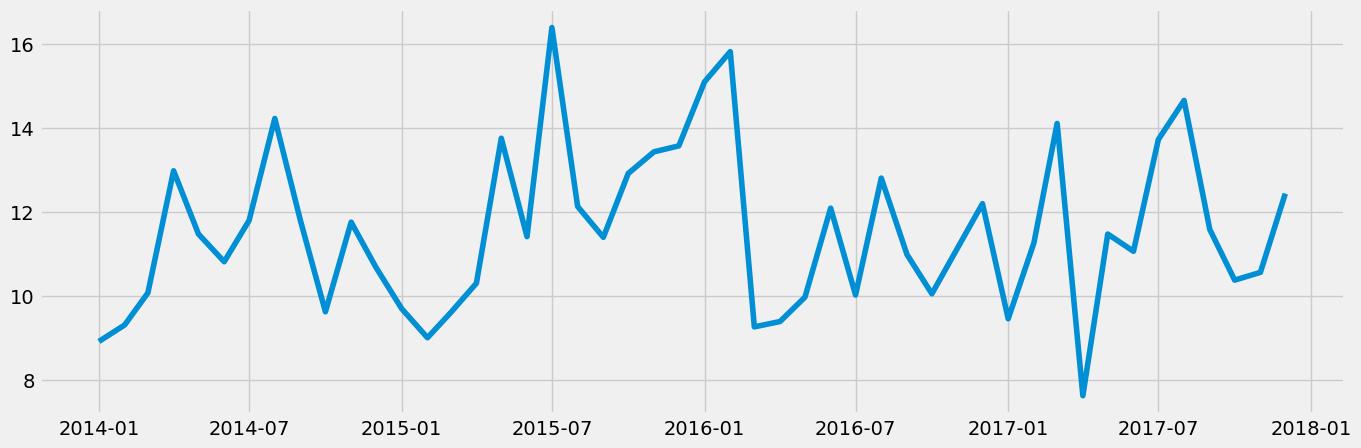

In [14]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(profit_per_month)

### 3. Time-series analysis: decomposition

In [15]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(profit_per_month, model='additive', period = 1)

In [16]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

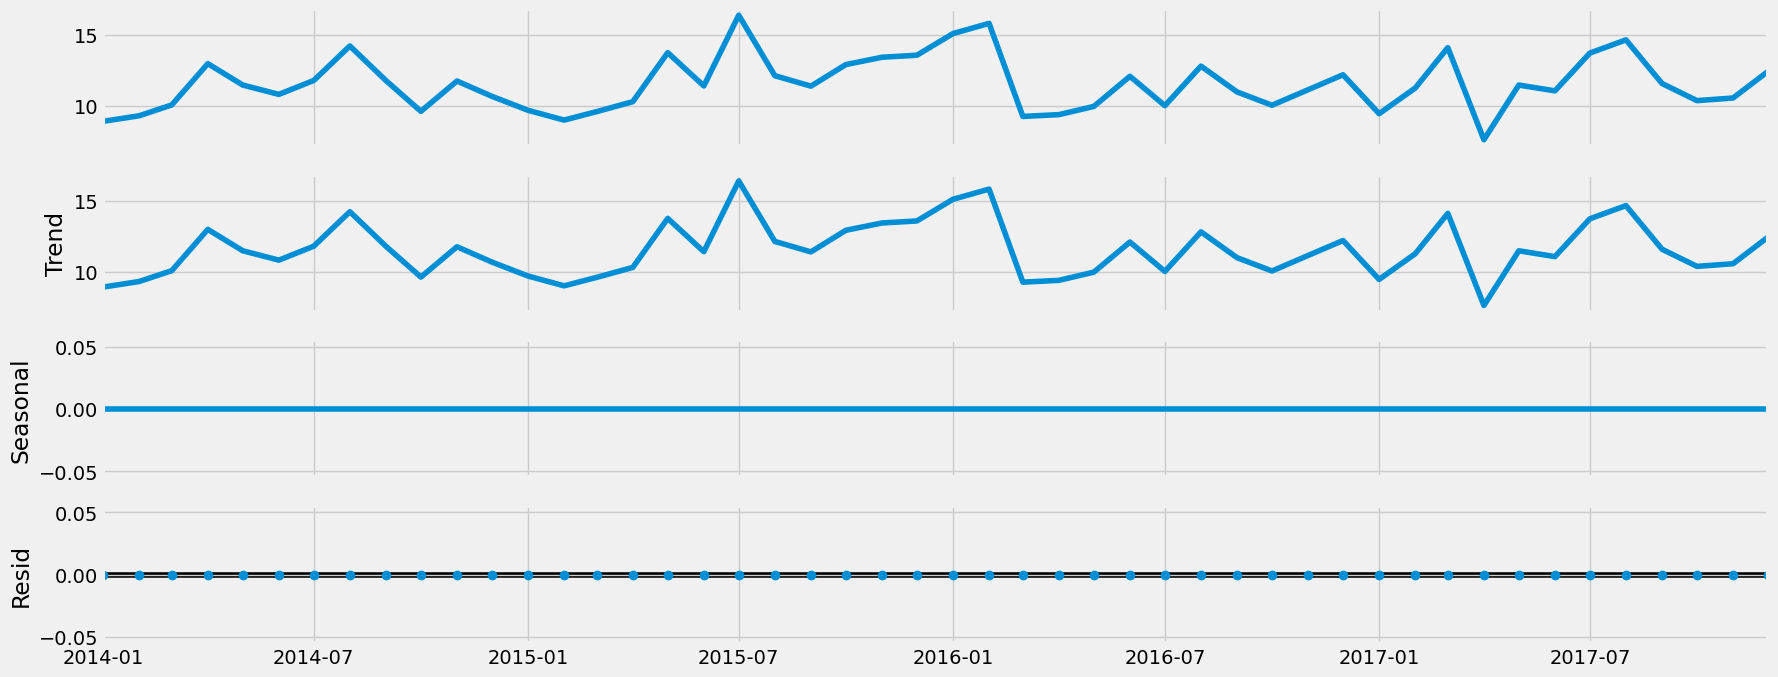

In [17]:
# Plot the separate components

decomposition.plot()
plt.show()

- Conclusions: 
There is no seasonality in the data, and the noise has been removed during Smoothing process.
The data seems to have no trend, indicating it might be starionary. Testing for stationarity is crucial.

### 4. Testing for stationarity

In [18]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why we need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(profit_per_month['Monthly_Profit'])

Dickey-Fuller Stationarity test:
Test Statistic                 -5.465938
p-value                         0.000002
Number of Lags Used             0.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


- Conclusion: 
p-value is <0.05 indicating a significant result. 
Test statistic is smaller than the critical value, which means the null hypothesis can be rejected. There isn't a unit root in the data, indicating the data is stationary. An auto-correlation check is needed to confirm non-stationarity


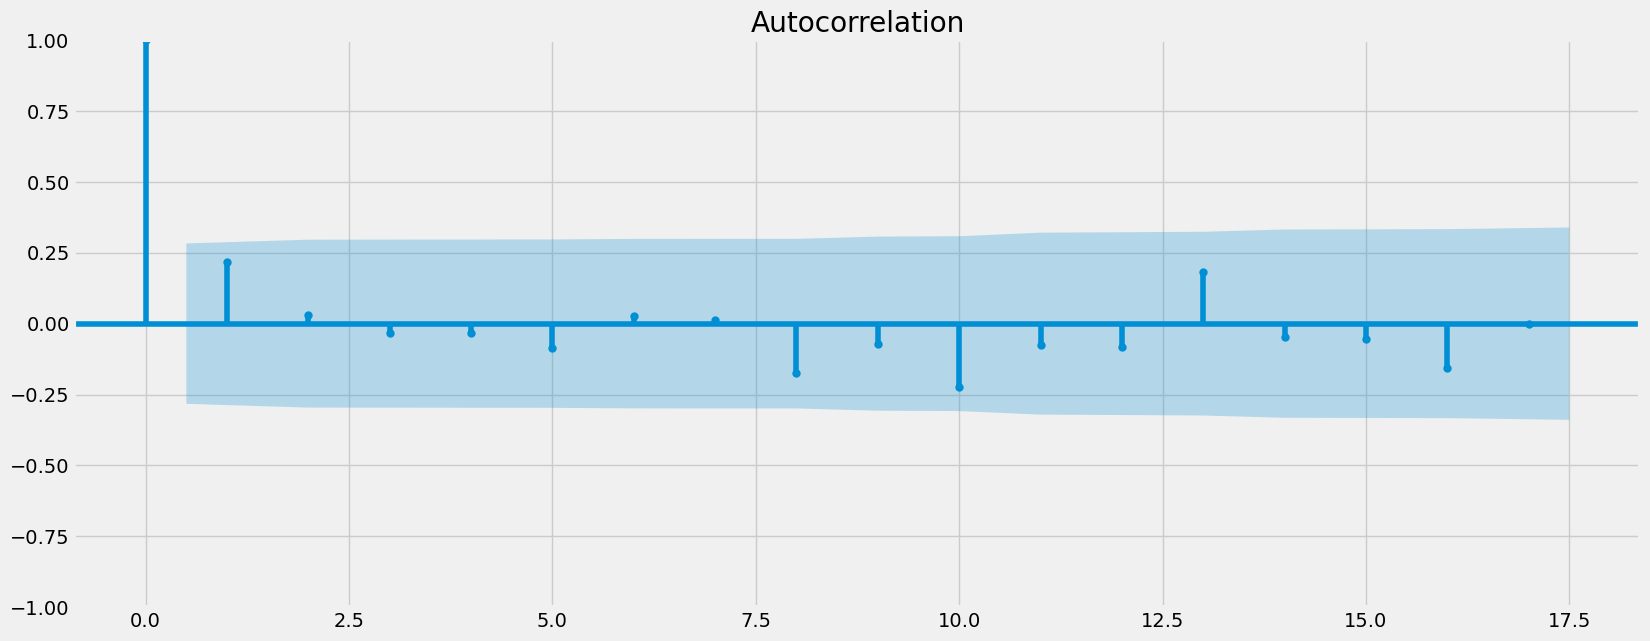

In [19]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(profit_per_month)
plt.show()

- Conclusion: there are very few vertical lines above the confidence interval, confirming the data is stationary.

KeyError: 'Order_Month'

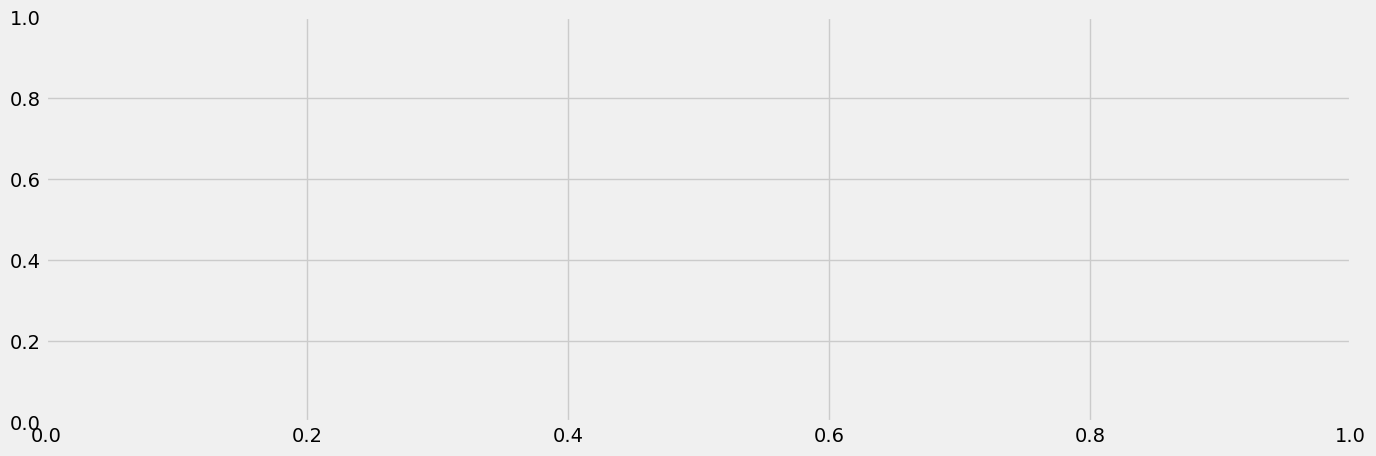

In [20]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15,5), dpi=100)

# Plot the average profit on the primary y-axis
ax1.plot(profit_per_month['Order_Month'], profit_per_month['Monthly_Profit'], color='blue', label='Average Profit')
ax1.set_xlabel('Order Month')
ax1.set_ylabel('Average Profit', color='blue')
ax1.tick_params('y', colors='blue')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the average discount on the secondary y-axis
ax2.plot(discount_per_date['Order_Date'], discount_per_date['Average_Discount'], color='green', label='Average Discount')
ax2.set_ylabel('Average Discount', color='green')
ax2.tick_params('y', colors='green')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()